In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'KR Variation 6 CNN Images Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Manulife Financial Corporation Stock Data

### No other stock price

In [5]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/KR_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,8.68750,9.252111,-93.750000,-7835000.0,2.0
2000-01-24,8.40625,9.121979,-96.428571,-15986000.0,2.0
2000-01-25,8.15625,8.973405,-93.939394,-27586200.0,1.0
2000-01-26,8.06250,8.833266,-92.857143,-35302800.0,2.0
2000-01-27,8.25000,8.743533,-83.076923,-22065800.0,2.0


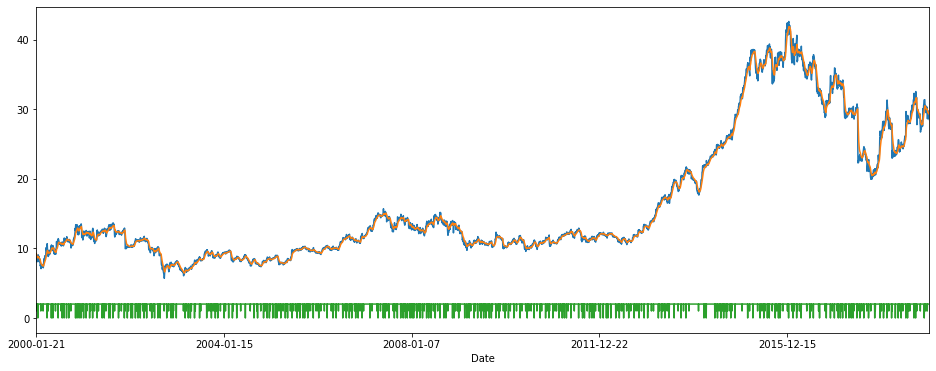

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [8]:
willr_data = np.array(willr_data)
willr_data.shape

(4745, 15, 1)

In [9]:
price_data = np.array(price_data)
price_data.shape

(4745, 15, 1)

In [10]:
ema_data = np.array(ema_data)
ema_data.shape

(4745, 15, 1)

In [11]:
obv_data = np.array(obv_data)
obv_data.shape

(4745, 15, 1)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [13]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

In [14]:
from collections import Counter

Counter(y)

Counter({2.0: 4315, 1.0: 215, 0.0: 215})

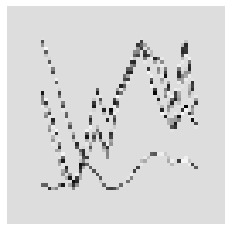

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.3565891472868215, 1: 7.3565891472868215, 2: 0.36655079181151023}
Epoch 1/200
 1/30 [>.............................] - ETA: 0s - loss: 0.3636 - accuracy: 0.7109 - mse: 5.5399 - weighted_accuracy: 0.4952 - weighted_mse: 5.2941WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 1s 36ms/step - loss: 0.2406 - accuracy: 0.3617 - mse: 1.6537 - weighted_accuracy: 0.3370 - weighted_mse: 1.6643 - val_loss: 0.2153 - val_accuracy: 0.0717 - val_mse: 0.8107 - val_weighted_accuracy: 0.0717 - val_weighted_mse: 0.8107
Epoch 2/200
30/30 [==============================] - 0s 15ms/step - loss: 0.2067 - accuracy: 0.3290 - mse: 1.1965 - weighted_accuracy: 0.3508 - weighted_mse: 1.1901 - val_loss: 0.2122 - val_accuracy: 0.0548 -

Epoch 27/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1959 - accuracy: 0.3224 - mse: 1.1823 - weighted_accuracy: 0.4110 - weighted_mse: 1.1680 - val_loss: 0.1896 - val_accuracy: 0.2645 - val_mse: 1.1002 - val_weighted_accuracy: 0.2645 - val_weighted_mse: 1.1002
Epoch 28/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1911 - accuracy: 0.3409 - mse: 1.2206 - weighted_accuracy: 0.4472 - weighted_mse: 1.1966 - val_loss: 0.1883 - val_accuracy: 0.2782 - val_mse: 0.9644 - val_weighted_accuracy: 0.2782 - val_weighted_mse: 0.9644
Epoch 29/200
30/30 [==============================] - 0s 16ms/step - loss: 0.1924 - accuracy: 0.2964 - mse: 1.2402 - weighted_accuracy: 0.4475 - weighted_mse: 1.2179 - val_loss: 0.1969 - val_accuracy: 0.1106 - val_mse: 0.9944 - val_weighted_accuracy: 0.1106 - val_weighted_mse: 0.9944
Epoch 30/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1898 - accuracy: 0.3135 - mse: 1.2366 - weighted_accuracy: 0.4593 - 

30/30 [==============================] - 0s 15ms/step - loss: 0.1672 - accuracy: 0.2766 - mse: 1.3720 - weighted_accuracy: 0.5636 - weighted_mse: 1.3084 - val_loss: 0.1946 - val_accuracy: 0.1686 - val_mse: 1.1610 - val_weighted_accuracy: 0.1686 - val_weighted_mse: 1.1610
Epoch 56/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1676 - accuracy: 0.2927 - mse: 1.4058 - weighted_accuracy: 0.5695 - weighted_mse: 1.3389 - val_loss: 0.1960 - val_accuracy: 0.1697 - val_mse: 1.0612 - val_weighted_accuracy: 0.1697 - val_weighted_mse: 1.0612
Epoch 57/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1713 - accuracy: 0.2750 - mse: 1.3200 - weighted_accuracy: 0.5630 - weighted_mse: 1.2476 - val_loss: 0.1895 - val_accuracy: 0.2139 - val_mse: 1.1595 - val_weighted_accuracy: 0.2139 - val_weighted_mse: 1.1595
Epoch 58/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1652 - accuracy: 0.2787 - mse: 1.3830 - weighted_accuracy: 0.5809 - weighted_mse:

Epoch 84/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1476 - accuracy: 0.3762 - mse: 1.4684 - weighted_accuracy: 0.6443 - weighted_mse: 1.4331 - val_loss: 0.1819 - val_accuracy: 0.3604 - val_mse: 1.2912 - val_weighted_accuracy: 0.3604 - val_weighted_mse: 1.2912
Epoch 85/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1452 - accuracy: 0.3851 - mse: 1.5085 - weighted_accuracy: 0.6605 - weighted_mse: 1.4784 - val_loss: 0.1945 - val_accuracy: 0.2497 - val_mse: 1.2814 - val_weighted_accuracy: 0.2497 - val_weighted_mse: 1.2814
Epoch 86/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1432 - accuracy: 0.4165 - mse: 1.5216 - weighted_accuracy: 0.6738 - weighted_mse: 1.4699 - val_loss: 0.1879 - val_accuracy: 0.3151 - val_mse: 1.4192 - val_weighted_accuracy: 0.3151 - val_weighted_mse: 1.4192
Epoch 87/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1457 - accuracy: 0.3801 - mse: 1.5030 - weighted_accuracy: 0.6439 - 

Epoch 113/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1268 - accuracy: 0.5063 - mse: 1.5711 - weighted_accuracy: 0.7104 - weighted_mse: 1.6602 - val_loss: 0.1737 - val_accuracy: 0.4858 - val_mse: 1.3233 - val_weighted_accuracy: 0.4858 - val_weighted_mse: 1.3233
Epoch 114/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1275 - accuracy: 0.5350 - mse: 1.6422 - weighted_accuracy: 0.7080 - weighted_mse: 1.7284 - val_loss: 0.1850 - val_accuracy: 0.4110 - val_mse: 1.4091 - val_weighted_accuracy: 0.4110 - val_weighted_mse: 1.4091
Epoch 115/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1191 - accuracy: 0.4947 - mse: 1.6562 - weighted_accuracy: 0.7393 - weighted_mse: 1.8288 - val_loss: 0.1639 - val_accuracy: 0.5501 - val_mse: 1.3877 - val_weighted_accuracy: 0.5501 - val_weighted_mse: 1.3877
Epoch 116/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1207 - accuracy: 0.5532 - mse: 1.6754 - weighted_accuracy: 0.744

Epoch 142/200
30/30 [==============================] - 0s 12ms/step - loss: 0.0997 - accuracy: 0.6272 - mse: 1.8674 - weighted_accuracy: 0.7897 - weighted_mse: 2.2452 - val_loss: 0.1384 - val_accuracy: 0.7028 - val_mse: 1.5734 - val_weighted_accuracy: 0.7028 - val_weighted_mse: 1.5734
Epoch 143/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1024 - accuracy: 0.6370 - mse: 1.7990 - weighted_accuracy: 0.7841 - weighted_mse: 2.1218 - val_loss: 0.1482 - val_accuracy: 0.6628 - val_mse: 1.5445 - val_weighted_accuracy: 0.6628 - val_weighted_mse: 1.5445
Epoch 144/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1021 - accuracy: 0.6315 - mse: 1.7625 - weighted_accuracy: 0.7857 - weighted_mse: 2.1218 - val_loss: 0.1512 - val_accuracy: 0.6523 - val_mse: 1.5303 - val_weighted_accuracy: 0.6523 - val_weighted_mse: 1.5303
Epoch 145/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1050 - accuracy: 0.6344 - mse: 1.7761 - weighted_accuracy: 0.768

Epoch 171/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0854 - accuracy: 0.6984 - mse: 2.0609 - weighted_accuracy: 0.8195 - weighted_mse: 2.7110 - val_loss: 0.1277 - val_accuracy: 0.7724 - val_mse: 1.5225 - val_weighted_accuracy: 0.7724 - val_weighted_mse: 1.5225
Epoch 172/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0909 - accuracy: 0.6965 - mse: 1.9237 - weighted_accuracy: 0.7912 - weighted_mse: 2.5216 - val_loss: 0.1455 - val_accuracy: 0.6902 - val_mse: 1.5463 - val_weighted_accuracy: 0.6902 - val_weighted_mse: 1.5463
Epoch 173/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0886 - accuracy: 0.6947 - mse: 1.9458 - weighted_accuracy: 0.8034 - weighted_mse: 2.5950 - val_loss: 0.1239 - val_accuracy: 0.7840 - val_mse: 1.5956 - val_weighted_accuracy: 0.7840 - val_weighted_mse: 1.5956
Epoch 174/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0816 - accuracy: 0.7208 - mse: 2.0883 - weighted_accuracy: 0.825

Epoch 200/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0648 - accuracy: 0.8288 - mse: 2.5880 - weighted_accuracy: 0.8673 - weighted_mse: 3.8198 - val_loss: 0.1132 - val_accuracy: 0.8040 - val_mse: 2.0027 - val_weighted_accuracy: 0.8040 - val_weighted_mse: 2.0027


In [22]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11318184435367584
Test accuracy: 0.8040041923522949


In [23]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.5405346  -0.47600284 -0.37559426]
 [-1.2322217  -0.9511049  -0.13624309]
 [-1.183392   -0.91013384 -0.17967981]
 ...
 [-2.5199397  -0.3512292  -0.26433313]
 [-0.9077335  -1.1501825  -0.26292616]
 [-2.8823767  -1.4867798   0.74361026]]


Counter({2: 832, 1: 68, 0: 49})

In [24]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 863, 0: 43, 1: 43})

In [25]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) 

number of predictions: 949
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 38
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 39
actual holds but predicted buy: 62
actual holds but predicted sell: 46
actual predicted holds: 755
Percentage buys correct: 11.627906976744185%
Percentage sells correct: 6.976744186046512%
Percentage holds correct: 87.48551564310544%
actual buys: 43
actual sells: 43
actual holds: 863


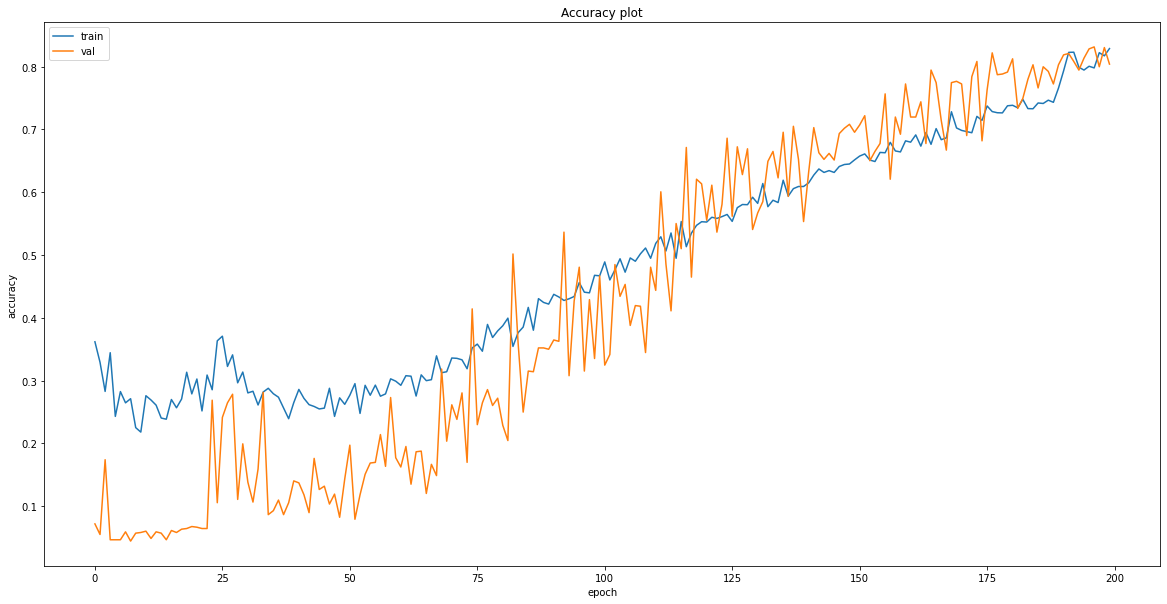

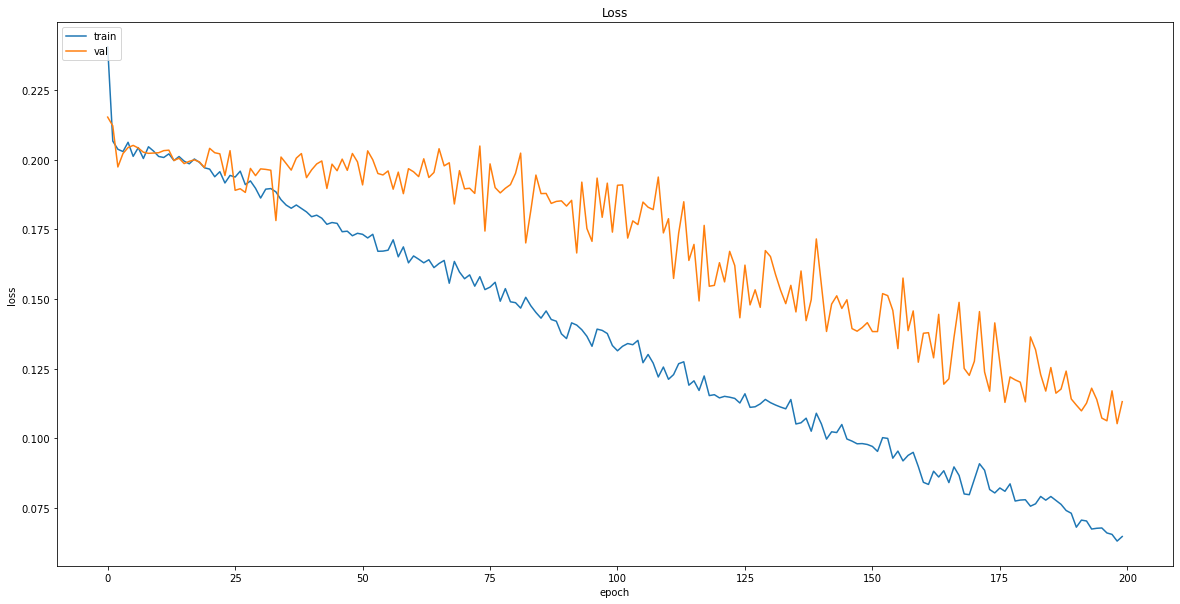

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Save model
model.save("models/{}".format('KR_no_support_image_cnn_buy_hold_sell.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/KR_no_support_image_cnn_buy_hold_sell.model\assets


### Test Performance

### Non-Recession Test Data

In [28]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [29]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/KR_data_test.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-22,29.430000,28.387007,-4.858258,41061300.0,2.0
2019-01-23,29.320000,28.530544,-9.311725,36484100.0,2.0
2019-01-24,29.240000,28.639691,-14.919380,31104500.0,2.0
2019-01-25,28.709999,28.650508,-38.135648,21525300.0,2.0
2019-01-28,28.120001,28.568891,-63.135567,13527400.0,2.0


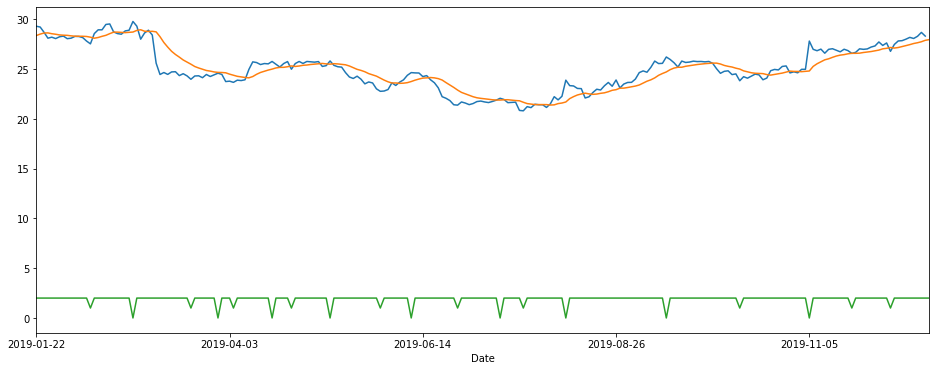

In [30]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [31]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [32]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [33]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [35]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [36]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [37]:
model = tf.keras.models.load_model("models/KR_no_support_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 10ms/step - loss: 0.1175 - accuracy: 0.8028 - mean_squared_error: 1.9429 - weighted_accuracy: 0.8028 - weighted_mean_squared_error: 1.9429
Test loss: 0.11754797399044037
Test accuracy: 0.8027523159980774


In [38]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 192, 1: 9, 0: 17})

In [39]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({1: 10, 2: 199, 0: 9})

In [40]:
df = pd.read_csv("data/variation 6/initial_indicators/KR_data_test.csv")
df.set_index('Date', inplace=True)

In [41]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,27.549999,28.220168,-89.447281,18063500.0,1.0,2,1
2019-02-12,28.580000,28.117065,-98.564652,13001800.0,2.0,1,2
2019-02-13,28.959999,28.188286,-45.077757,21452700.0,2.0,2,2
2019-02-14,28.959999,28.307011,-7.096817,27986100.0,2.0,2,2
2019-02-15,29.500000,28.407471,-25.388684,27986100.0,2.0,2,2


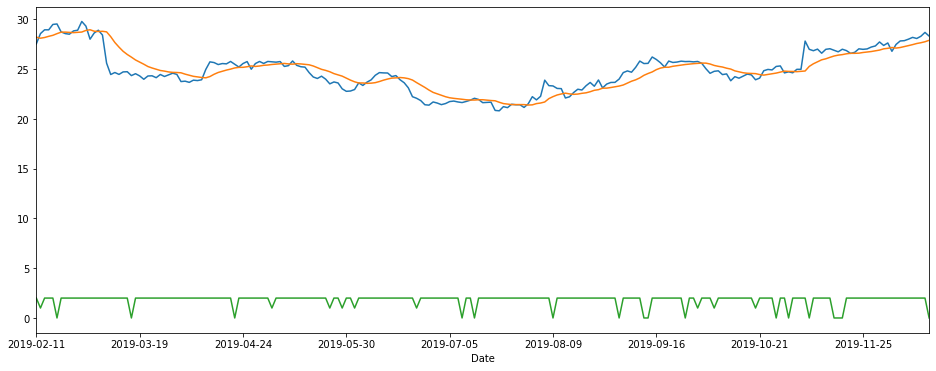

In [42]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

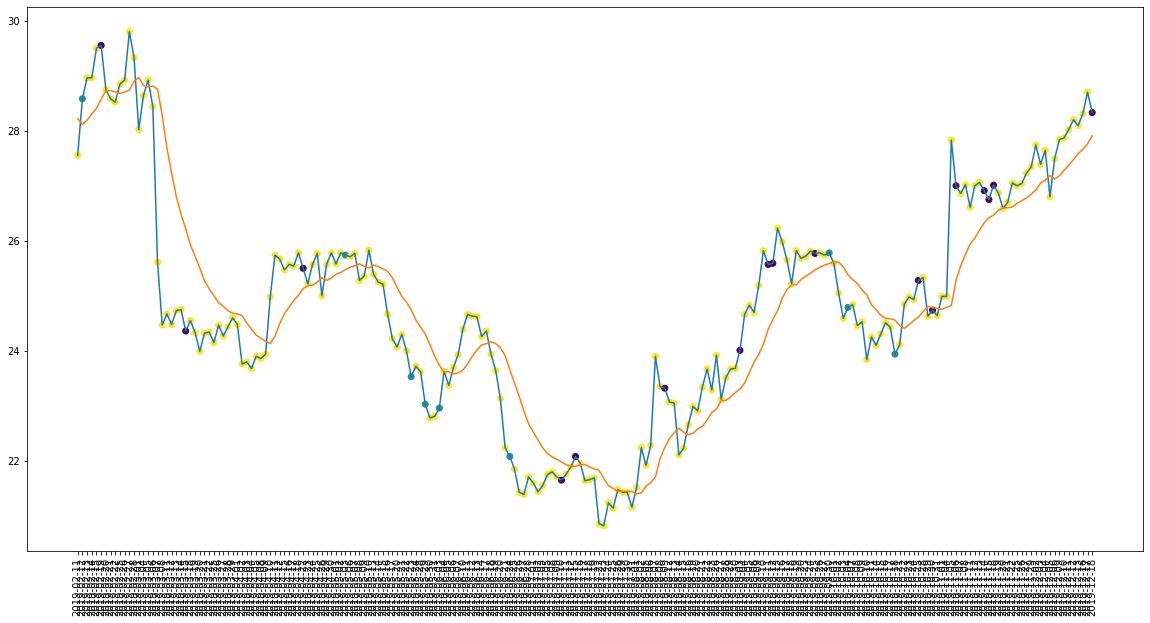

In [43]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

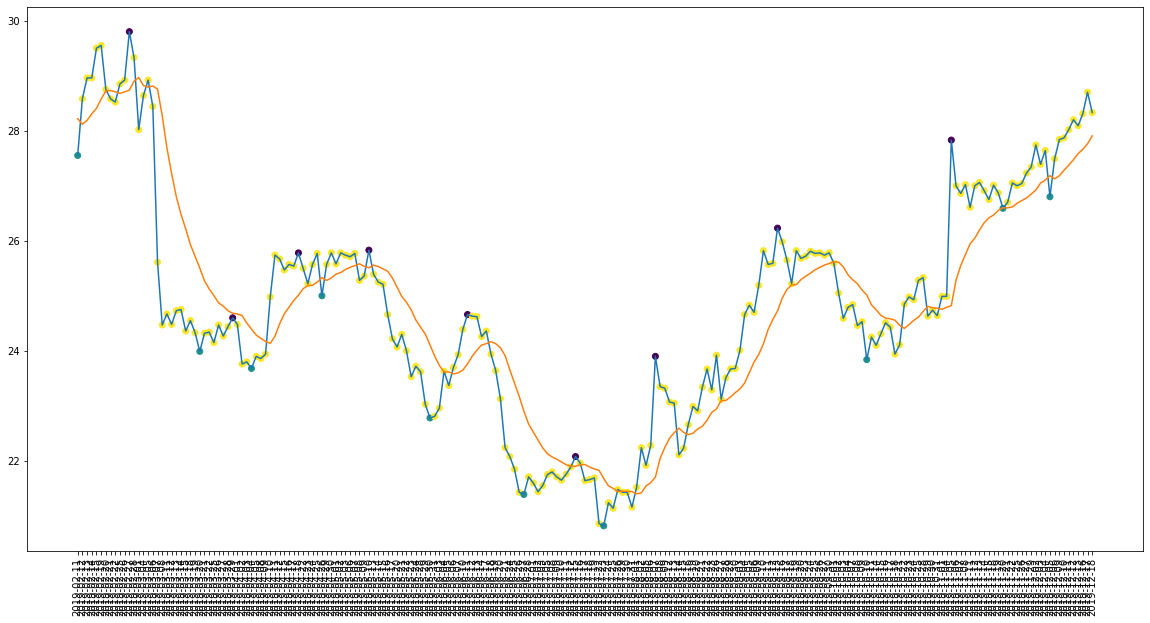

In [44]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [45]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 9
actual holds but predicted sell: 16
actual predicted holds: 174
Percentage buys correct: 0.0%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 87.43718592964824%
actual buys: 10
actual sells: 9
actual holds: 199


In [46]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[27.54999923706055, 28.520000457763672, 28.57999992370605, 28.57999992370605, 28.75, 28.959999084472656, 28.959999084472656, 29.5, 29.54999923706055]
[28.020000457763672, 28.520000457763672, 28.57999992370605, 28.63999938964844, 28.75, 28.85000038146973, 28.920000076293945, 29.32999992370605, 29.79999923706055]
Percentage buys correct: 55.55555555555556%
Percentage sells correct: 41.1764705882353%
Percentage holds correct: 82.19895287958116%


In [47]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $28.57999992370605
Shares owned at the moment: 348
Cash capital at the moment: $26.80896662330815


Stop Loss Activated!

Share price: $25.61000061035156
Shares owned at the moment: 0
Cash capital at the moment: $8914.580408441543


Share price: $25.739999771118164
Shares owned at the moment: 345
Cash capital at the moment: $9.859662622928226


Stop Loss Activated!

Share price: $24.65999984741211
Shares owned at the moment: 0
Cash capital at the moment: $8494.163435124874


Share price: $23.53000068664551
Shares owned at the moment: 360
Cash capital at the moment: $0.06848725271083822


Stop Loss Activated!

Share price: $22.78000068664551
Shares owned at the moment: 0
Cash capital at the moment: $8178.316533765316


Share price: $22.959999084472656
Shares owned at the moment: 355
Cash capital at the moment: $5.102159671306254


Stop Loss Activated!

Share price: $22.239999771118164
Shares owned at the moment: 0
Cash capital at the moment: $7878.5902786417


Share price: 

In [48]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10226.105378712173
profit gained: 2.2610537871217273%


In [49]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.802752,0.0%,11.11111111111111%,87.43718592964824%,55.55555555555556%,41.1764705882353%,82.19895287958116%,-26.182976346344933%,2.2610537871217273%


### Recession test data

In [50]:
logger = []

In [51]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/KR_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2020-01-22    28.410000  28.475794 -65.217413  9500700.0     2.0
2020-01-23    28.370001  28.459518 -68.695589  4678900.0     2.0
2020-01-24    28.440001  28.456515 -52.222168  8638500.0     2.0
2020-01-27    28.190001  28.415513 -79.999958  3996300.0     2.0
2020-01-28    28.330000  28.402357 -50.434793  8238000.0     2.0


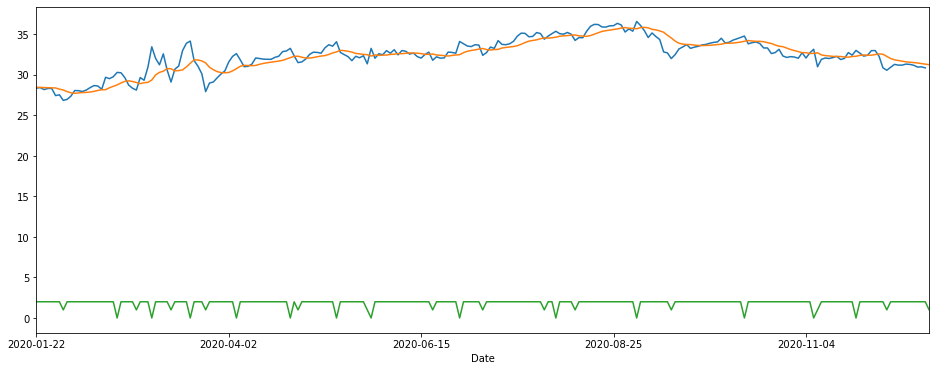

In [52]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [53]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [54]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [56]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [57]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [58]:
model = tf.keras.models.load_model("models/KR_no_support_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 11ms/step - loss: 0.1210 - accuracy: 0.7808 - mean_squared_error: 1.9934 - weighted_accuracy: 0.7808 - weighted_mean_squared_error: 1.9934
Test loss: 0.12095434963703156
Test accuracy: 0.7808219194412231


In [59]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 187, 0: 16, 1: 16})

In [60]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [61]:
df = pd.read_csv("data/variation 6/initial_indicators/KR_data_test2.csv")
df.set_index('Date', inplace=True)

In [62]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,28.440001,27.892005,-25.654440,10558800.0,2.0,2,2
2020-02-12,28.690001,27.976312,-9.473693,14655000.0,2.0,2,2
2020-02-13,28.629999,28.086110,-7.075451,19030600.0,2.0,2,2
2020-02-14,28.230000,28.169785,-9.905703,15348600.0,2.0,2,2
2020-02-18,29.709999,28.179049,-28.773602,10540700.0,2.0,2,2


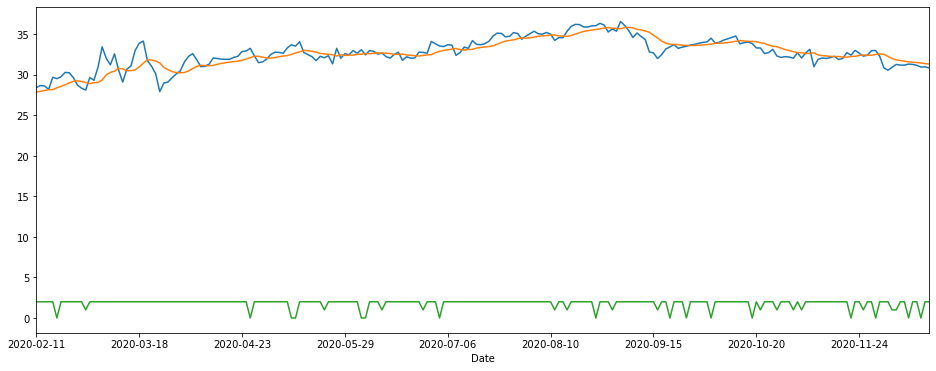

In [63]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

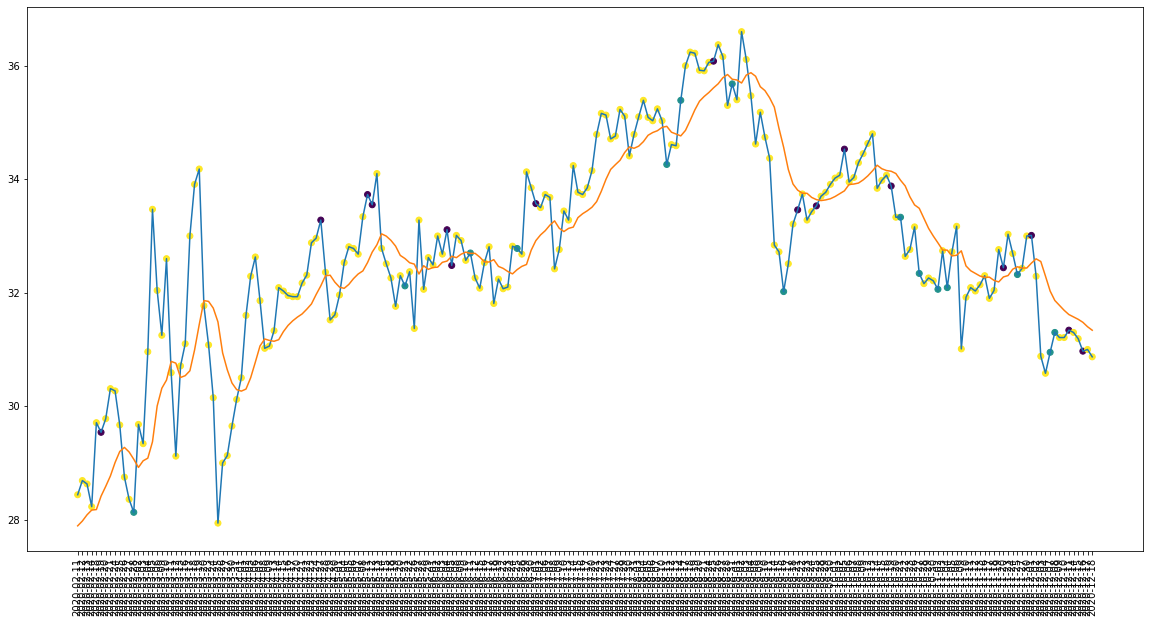

In [64]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

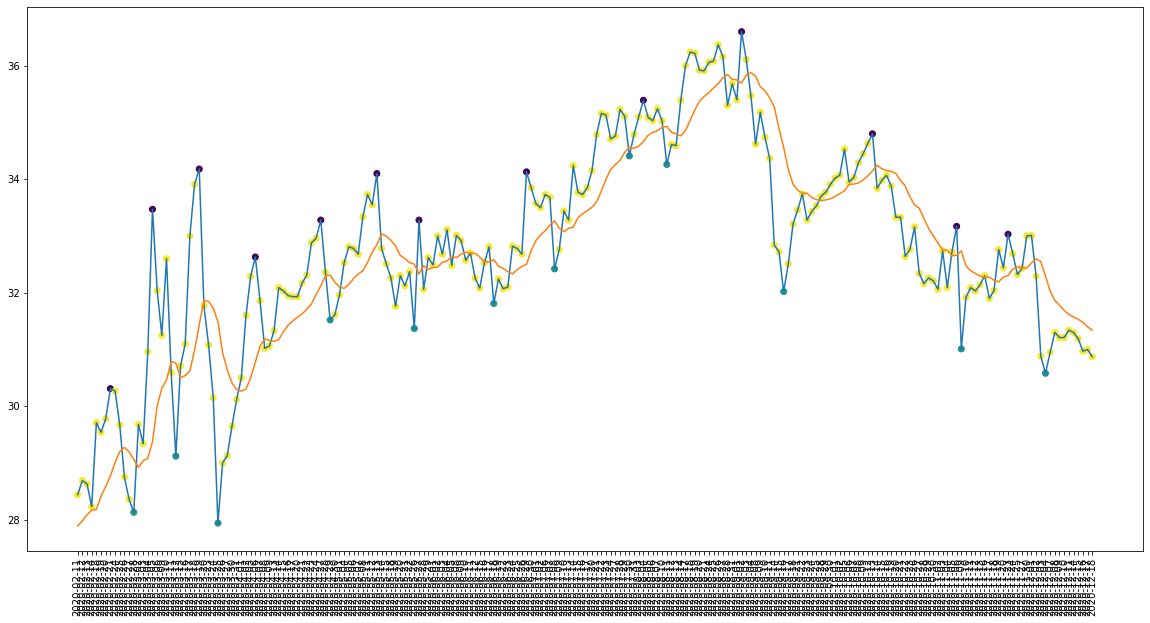

In [65]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [66]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 12
actual holds but predicted buy: 12
actual holds but predicted sell: 15
actual predicted holds: 166
Percentage buys correct: 30.76923076923077%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 86.01036269430051%
actual buys: 13
actual sells: 13
actual holds: 193


In [67]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[28.229999542236328, 28.440000534057607, 28.6299991607666, 28.690000534057607, 29.540000915527344, 29.709999084472656, 29.78000068664551, 30.270000457763672, 30.309999465942386]
[28.1299991607666, 28.36000061035156, 28.75, 29.34000015258789, 29.670000076293945, 29.68000030517578, 29.78000068664551, 30.270000457763672, 30.309999465942386]
Percentage buys correct: 60.0%
Percentage sells correct: 68.75%
Percentage holds correct: 81.28342245989305%


In [68]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $28.1299991607666
Shares owned at the moment: 354
Cash capital at the moment: $14.595742905616135


Price increase from previously bought: 17.98340121784152%
Share price: $33.279998779296875
Shares owned at the moment: 0
Cash capital at the moment: $11763.317231965064


Share price: $32.11999893188477
Shares owned at the moment: 365
Cash capital at the moment: $7.277172899242942


Price increase from previously bought: 12.0207195804795%
Share price: $36.08000183105469
Shares owned at the moment: 0
Cash capital at the moment: $13140.262539396283


Share price: $35.68000030517578
Shares owned at the moment: 367
Cash capital at the moment: $9.692387088771284


Stop Loss Activated!

Share price: $34.61999893188477
Shares owned at the moment: 0
Cash capital at the moment: $12680.291761168477


Share price: $32.02000045776367
Shares owned at the moment: 394
Cash capital at the moment: $29.71791031360226


Price increase from previously bought: 7.54310183425877%
Share price: $34.

In [69]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10793.414230489732
profit gained: 7.934142304897322%


In [70]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.802752,0.0%,11.11111111111111%,87.43718592964824%,55.55555555555556%,41.1764705882353%,82.19895287958116%,-26.182976346344933%,2.2610537871217273%
1,0.780822,30.76923076923077%,7.6923076923076925%,86.01036269430051%,60.0%,68.75%,81.28342245989305%,17.954822250075267%,7.934142304897322%


### with WMT stock price

In [71]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/KR_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,8.68750,9.252111,-93.750000,-7835000.0,2.0
2000-01-24,8.40625,9.121979,-96.428571,-15986000.0,2.0
2000-01-25,8.15625,8.973405,-93.939394,-27586200.0,1.0
2000-01-26,8.06250,8.833266,-92.857143,-35302800.0,2.0
2000-01-27,8.25000,8.743533,-83.076923,-22065800.0,2.0


In [72]:
df2 = pd.read_csv("data/variation 6/initial_indicators/WMT_data.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,63.3750,65.176128,-85.271318,-26649200.0,2.0
2000-01-24,62.4375,64.754801,-94.594595,-33601700.0,2.0
2000-01-25,59.3750,63.927139,-83.606557,-41401600.0,2.0
2000-01-26,61.1250,63.496041,-68.306011,-34997800.0,2.0
2000-01-27,61.9375,63.256265,-61.202186,-30459400.0,2.0


In [73]:
df['support'] = df2['previous_1d']
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,support
Date,,,,,,
2000-01-21,8.68750,9.252111,-93.750000,-7835000.0,2.0,63.3750
2000-01-24,8.40625,9.121979,-96.428571,-15986000.0,2.0,62.4375
2000-01-25,8.15625,8.973405,-93.939394,-27586200.0,1.0,59.3750
2000-01-26,8.06250,8.833266,-92.857143,-35302800.0,2.0,61.1250
2000-01-27,8.25000,8.743533,-83.076923,-22065800.0,2.0,61.9375


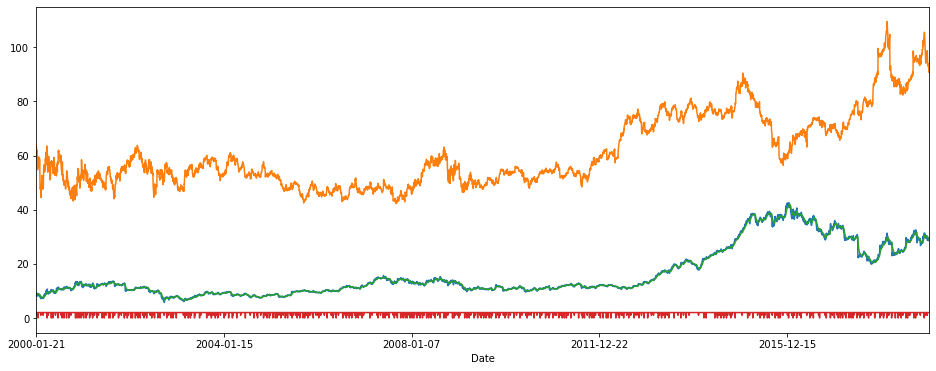

In [74]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['support'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [75]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
support_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
data_15_support = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        support_data.append(data_15_support_arr)
        labels.append(i[4])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
        data_15_support = data_15_support[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
support_data = np.array(support_data)

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    n = support_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)
    ax.plot(n)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [77]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

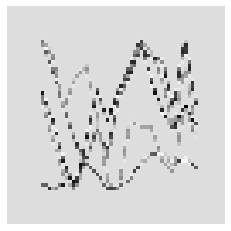

In [78]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [79]:
X = X/255

In [80]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [81]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [82]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [83]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [84]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.3565891472868215, 1: 7.3565891472868215, 2: 0.36655079181151023}
Epoch 1/200
30/30 [==============================] - 2s 75ms/step - loss: 0.2403 - accuracy: 0.3683 - mse: 1.6356 - weighted_accuracy: 0.3265 - weighted_mse: 1.6529 - val_loss: 0.2183 - val_accuracy: 0.0464 - val_mse: 0.7636 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.7636
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2057 - accuracy: 0.3714 - mse: 1.1878 - weighted_accuracy: 0.3424 - weighted_mse: 1.1948 - val_loss: 0.2007 - val_accuracy: 0.0632 - val_mse: 0.9773 - val_weighted_accuracy: 0.0632 - val_weighted_mse: 0.9773
Epoch 3/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2046 - accuracy: 0.3138 - mse: 1.2069 - weighted_accuracy: 0.3305 - weighted_mse: 1.1846 - val_loss: 0.2117 - val_accuracy: 0.0485 - val_mse: 0.9683 - val_weighted_accuracy: 0.0485 - val_weighted_mse: 0.9683
Epoch 4/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2

30/30 [==============================] - 0s 10ms/step - loss: 0.1964 - accuracy: 0.3941 - mse: 1.1794 - weighted_accuracy: 0.3894 - weighted_mse: 1.1947 - val_loss: 0.1921 - val_accuracy: 0.4436 - val_mse: 0.9277 - val_weighted_accuracy: 0.4436 - val_weighted_mse: 0.9277
Epoch 29/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1983 - accuracy: 0.3135 - mse: 1.1822 - weighted_accuracy: 0.3506 - weighted_mse: 1.1919 - val_loss: 0.2002 - val_accuracy: 0.0611 - val_mse: 1.0468 - val_weighted_accuracy: 0.0611 - val_weighted_mse: 1.0468
Epoch 30/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1963 - accuracy: 0.3045 - mse: 1.1808 - weighted_accuracy: 0.3768 - weighted_mse: 1.1689 - val_loss: 0.1900 - val_accuracy: 0.4889 - val_mse: 0.9641 - val_weighted_accuracy: 0.4889 - val_weighted_mse: 0.9641
Epoch 31/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1956 - accuracy: 0.2921 - mse: 1.1788 - weighted_accuracy: 0.4128 - weighted_mse:

Epoch 57/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1831 - accuracy: 0.2110 - mse: 1.2823 - weighted_accuracy: 0.4917 - weighted_mse: 1.2270 - val_loss: 0.1930 - val_accuracy: 0.1475 - val_mse: 1.0422 - val_weighted_accuracy: 0.1475 - val_weighted_mse: 1.0422
Epoch 58/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1788 - accuracy: 0.2218 - mse: 1.2657 - weighted_accuracy: 0.5325 - weighted_mse: 1.2351 - val_loss: 0.1895 - val_accuracy: 0.1718 - val_mse: 1.0717 - val_weighted_accuracy: 0.1718 - val_weighted_mse: 1.0717
Epoch 59/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1787 - accuracy: 0.2318 - mse: 1.2976 - weighted_accuracy: 0.5122 - weighted_mse: 1.2469 - val_loss: 0.1952 - val_accuracy: 0.1159 - val_mse: 1.0419 - val_weighted_accuracy: 0.1159 - val_weighted_mse: 1.0419
Epoch 60/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1769 - accuracy: 0.2031 - mse: 1.3118 - weighted_accuracy: 0.5311 - 

Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1559 - accuracy: 0.2268 - mse: 1.4204 - weighted_accuracy: 0.6098 - weighted_mse: 1.3717 - val_loss: 0.1931 - val_accuracy: 0.1918 - val_mse: 1.2577 - val_weighted_accuracy: 0.1918 - val_weighted_mse: 1.2577
Epoch 87/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1596 - accuracy: 0.2505 - mse: 1.4277 - weighted_accuracy: 0.5890 - weighted_mse: 1.3539 - val_loss: 0.1931 - val_accuracy: 0.1855 - val_mse: 1.3020 - val_weighted_accuracy: 0.1855 - val_weighted_mse: 1.3020
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1548 - accuracy: 0.2524 - mse: 1.4483 - weighted_accuracy: 0.6081 - weighted_mse: 1.4072 - val_loss: 0.1958 - val_accuracy: 0.1623 - val_mse: 1.2888 - val_weighted_accuracy: 0.1623 - val_weighted_mse: 1.2888
Epoch 89/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1570 - accuracy: 0.2437 - mse: 1.4333 - weighted_accuracy: 0.6086 - we

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1334 - accuracy: 0.3596 - mse: 1.6701 - weighted_accuracy: 0.7045 - weighted_mse: 1.7275 - val_loss: 0.1955 - val_accuracy: 0.2403 - val_mse: 1.4927 - val_weighted_accuracy: 0.2403 - val_weighted_mse: 1.4927
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1366 - accuracy: 0.3859 - mse: 1.6218 - weighted_accuracy: 0.6957 - weighted_mse: 1.6880 - val_loss: 0.1787 - val_accuracy: 0.3836 - val_mse: 1.3812 - val_weighted_accuracy: 0.3836 - val_weighted_mse: 1.3812
Epoch 117/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1331 - accuracy: 0.3612 - mse: 1.6637 - weighted_accuracy: 0.6995 - weighted_mse: 1.7680 - val_loss: 0.1762 - val_accuracy: 0.4173 - val_mse: 1.4145 - val_weighted_accuracy: 0.4173 - val_weighted_mse: 1.4145
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1340 - accuracy: 0.3975 - mse: 1.6554 - weighted_accuracy: 0.7110 -

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1123 - accuracy: 0.5345 - mse: 1.9130 - weighted_accuracy: 0.7962 - weighted_mse: 2.2396 - val_loss: 0.1618 - val_accuracy: 0.5574 - val_mse: 1.6328 - val_weighted_accuracy: 0.5574 - val_weighted_mse: 1.6328
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1163 - accuracy: 0.5416 - mse: 1.9258 - weighted_accuracy: 0.7823 - weighted_mse: 2.1867 - val_loss: 0.1487 - val_accuracy: 0.6280 - val_mse: 1.6392 - val_weighted_accuracy: 0.6280 - val_weighted_mse: 1.6392
Epoch 146/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1128 - accuracy: 0.5603 - mse: 1.9188 - weighted_accuracy: 0.7910 - weighted_mse: 2.1670 - val_loss: 0.1633 - val_accuracy: 0.5448 - val_mse: 1.6810 - val_weighted_accuracy: 0.5448 - val_weighted_mse: 1.6810
Epoch 147/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1129 - accuracy: 0.5522 - mse: 1.9686 - weighted_accuracy: 0.8064 

Epoch 173/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0967 - accuracy: 0.6668 - mse: 2.2588 - weighted_accuracy: 0.8337 - weighted_mse: 2.8681 - val_loss: 0.1402 - val_accuracy: 0.6902 - val_mse: 1.7803 - val_weighted_accuracy: 0.6902 - val_weighted_mse: 1.7803
Epoch 174/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0987 - accuracy: 0.6552 - mse: 2.1498 - weighted_accuracy: 0.8294 - weighted_mse: 2.6804 - val_loss: 0.1297 - val_accuracy: 0.7345 - val_mse: 1.7189 - val_weighted_accuracy: 0.7345 - val_weighted_mse: 1.7189
Epoch 175/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0946 - accuracy: 0.6523 - mse: 2.2467 - weighted_accuracy: 0.8412 - weighted_mse: 2.8797 - val_loss: 0.1466 - val_accuracy: 0.6660 - val_mse: 1.8465 - val_weighted_accuracy: 0.6660 - val_weighted_mse: 1.8465
Epoch 176/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0946 - accuracy: 0.6654 - mse: 2.2753 - weighted_accuracy: 0.840

In [85]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11830966174602509
Test accuracy: 0.7829294204711914


In [86]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.463781   -0.57397586 -0.2405124 ]
 [-1.8478794  -0.51786995 -0.29518813]
 [-1.0197719  -0.9895246  -0.20220146]
 ...
 [-1.9727592  -0.7986946  -0.09622519]
 [-1.3087103  -0.9627185  -0.11000134]
 [-1.1432114  -1.5649644   0.20804238]]


Counter({2: 806, 1: 83, 0: 60})

In [87]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 863, 0: 43, 1: 43})

In [88]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 34
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 40
actual holds but predicted buy: 75
actual holds but predicted sell: 56
actual predicted holds: 732
Percentage buys correct: 18.6046511627907%
Percentage sells correct: 6.976744186046512%
Percentage holds correct: 84.82039397450754%
actual buys: 43
actual sells: 43
actual holds: 863


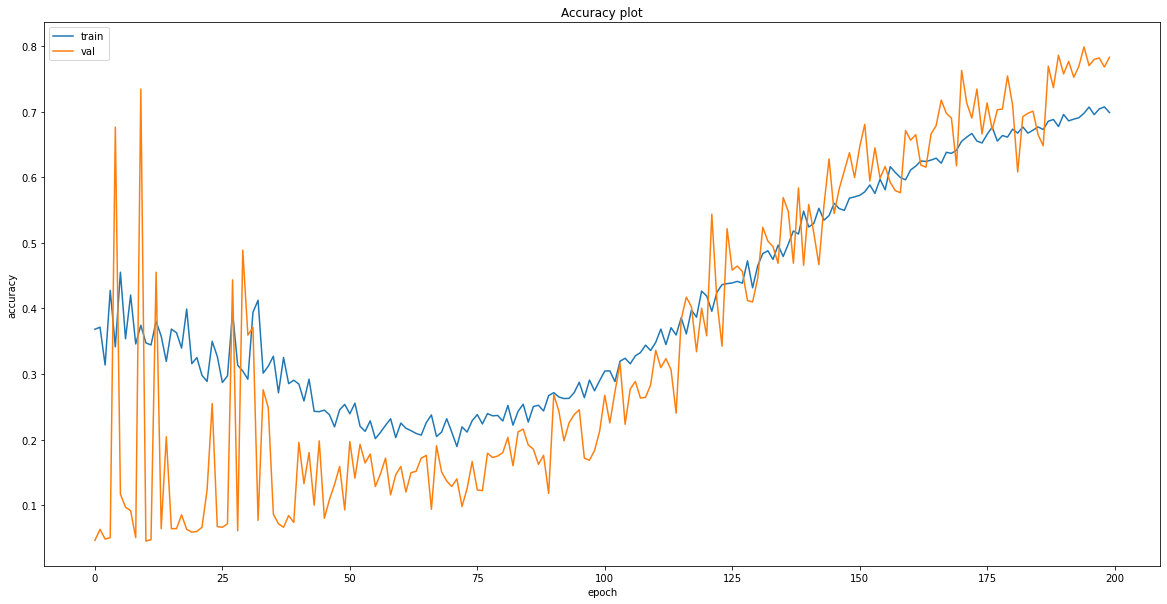

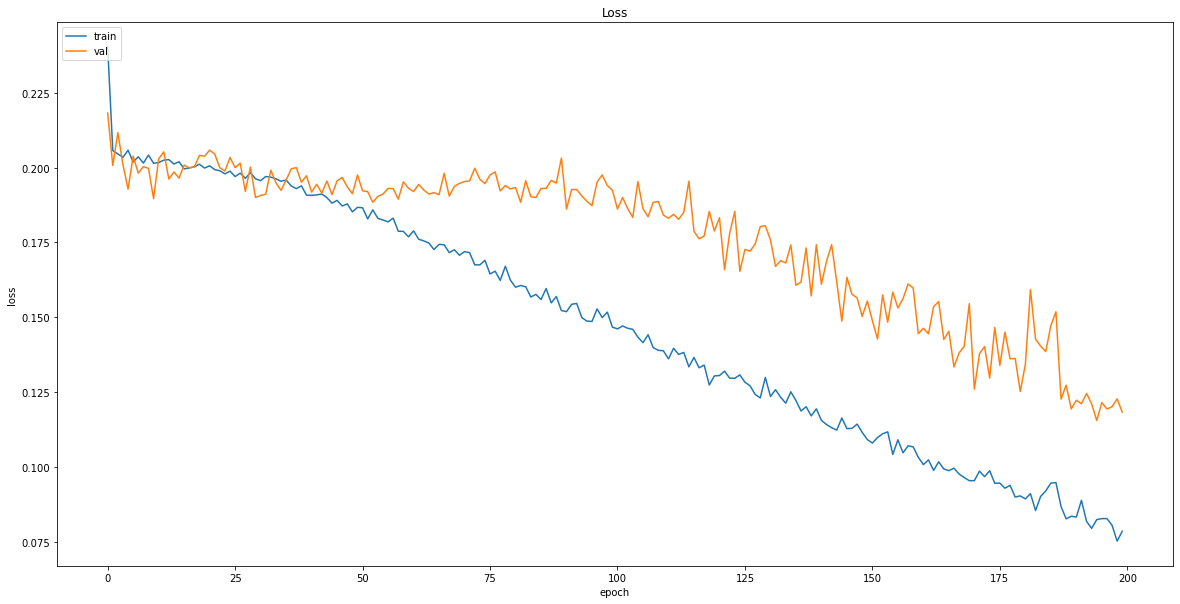

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [90]:
# Save model
model.save("models/{}".format('KR_support_image_cnn_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/KR_support_image_cnn_buy_hold_sell.model\assets


### Test Performance

### non-recession

In [91]:
logger = []

In [92]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/KR_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    29.430000  28.387007  -4.858258  41061300.0     2.0
2019-01-23    29.320000  28.530544  -9.311725  36484100.0     2.0
2019-01-24    29.240000  28.639691 -14.919380  31104500.0     2.0
2019-01-25    28.709999  28.650508 -38.135648  21525300.0     2.0
2019-01-28    28.120001  28.568891 -63.135567  13527400.0     2.0


In [93]:
df2 = pd.read_csv("data/variation 6/initial_indicators/WMT_data_test.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-22,97.730003,95.334462,-7.164539,58918700.0,2.0
2019-01-23,97.489998,95.666083,-13.843922,50855500.0,0.0
2019-01-24,98.709999,96.134378,-9.609606,59201300.0,2.0
2019-01-25,98.360001,96.476781,-14.864842,51591600.0,2.0
2019-01-28,96.940002,96.548046,-38.683751,44373400.0,2.0


In [94]:
df['support'] = df2['previous_1d']
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,support
Date,,,,,,
2019-01-22,29.430000,28.387007,-4.858258,41061300.0,2.0,97.730003
2019-01-23,29.320000,28.530544,-9.311725,36484100.0,2.0,97.489998
2019-01-24,29.240000,28.639691,-14.919380,31104500.0,2.0,98.709999
2019-01-25,28.709999,28.650508,-38.135648,21525300.0,2.0,98.360001
2019-01-28,28.120001,28.568891,-63.135567,13527400.0,2.0,96.940002


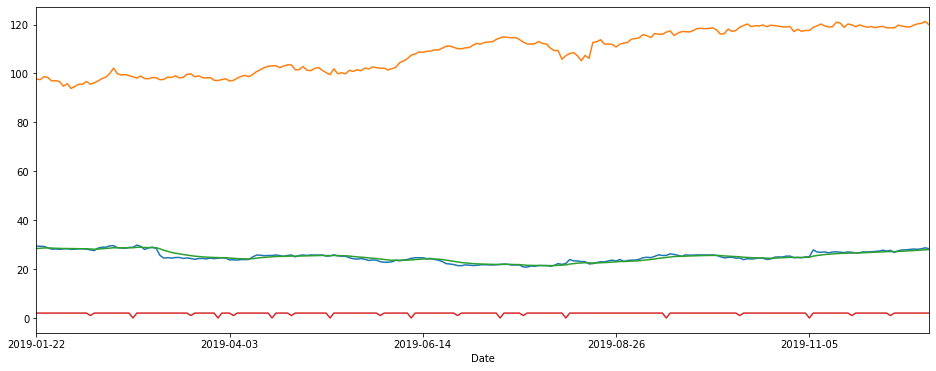

In [95]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['support'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [96]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
support_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
data_15_support = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        support_data.append(data_15_support_arr)
        labels.append(i[4])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
        data_15_support = data_15_support[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
support_data = np.array(support_data)

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [98]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [99]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [100]:
model = tf.keras.models.load_model("models/KR_support_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1106 - accuracy: 0.8211 - mean_squared_error: 1.9203 - weighted_accuracy: 0.8211 - weighted_mean_squared_error: 1.9203
Test loss: 0.11063499003648758
Test accuracy: 0.8211008906364441


In [101]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 19, 2: 188, 0: 11})

In [102]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({1: 10, 2: 199, 0: 9})

In [103]:
df = pd.read_csv("data/variation 6/initial_indicators/KR_data_test.csv")
df.set_index('Date', inplace=True)

In [104]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,27.549999,28.220168,-89.447281,18063500.0,1.0,1,1
2019-02-12,28.580000,28.117065,-98.564652,13001800.0,2.0,1,2
2019-02-13,28.959999,28.188286,-45.077757,21452700.0,2.0,2,2
2019-02-14,28.959999,28.307011,-7.096817,27986100.0,2.0,2,2
2019-02-15,29.500000,28.407471,-25.388684,27986100.0,2.0,2,2


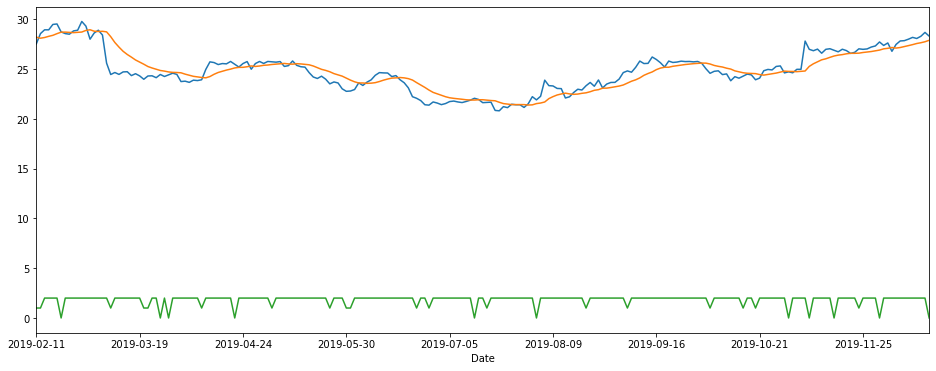

In [105]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

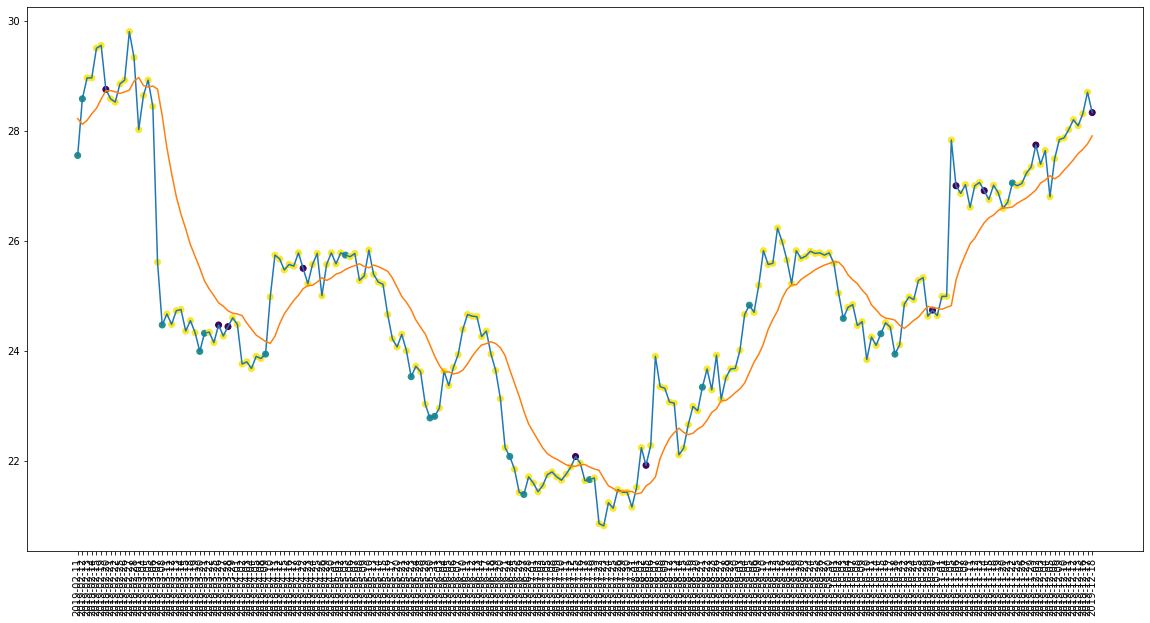

In [106]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

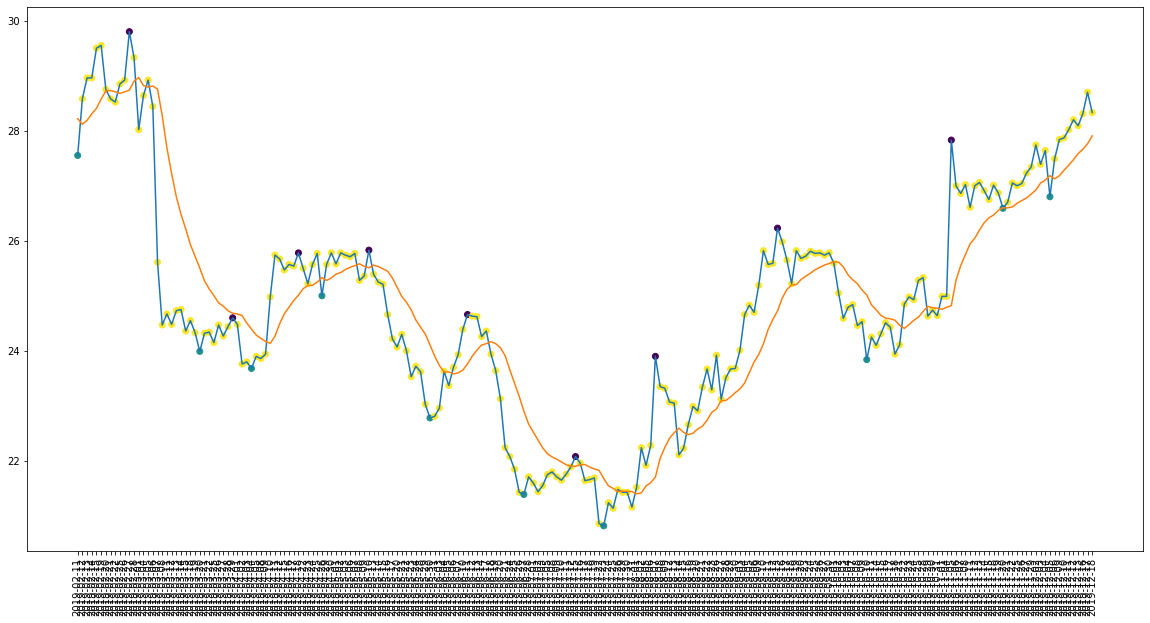

In [107]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [108]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 15
actual holds but predicted sell: 10
actual predicted holds: 174
Percentage buys correct: 40.0%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 87.43718592964824%
actual buys: 10
actual sells: 9
actual holds: 199
[27.54999923706055, 28.520000457763672, 28.57999992370605, 28.57999992370605, 28.75, 28.959999084472656, 28.959999084472656, 29.5, 29.54999923706055]
[28.020000457763672, 28.520000457763672, 28.57999992370605, 28.63999938964844, 28.75, 28.85000038146973, 28.920000076293945, 29.32999992370605, 29.79999923706055]
Percentage buys correct: 57.89473684210526%
Percentage sells correct: 54.54545454545455%
Percentage holds correct: 84.49197860962566%


In [109]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $27.54999923706055
Shares owned at the moment: 361
Cash capital at the moment: $27.10001367854784


Stop Loss Activated!

Share price: $25.61000061035156
Shares owned at the moment: 0
Cash capital at the moment: $9246.885905909534


Share price: $24.46999931335449
Shares owned at the moment: 376
Cash capital at the moment: $20.864184798238057


Stop Loss Activated!

Share price: $23.76000022888184
Shares owned at the moment: 0
Cash capital at the moment: $8930.056430621145


Share price: $23.940000534057607
Shares owned at the moment: 371
Cash capital at the moment: $23.891446940901005


Price increase from previously bought: 6.224171877969087%
Share price: $25.5
Shares owned at the moment: 0
Cash capital at the moment: $9458.3750719409


Share price: $25.739999771118164
Shares owned at the moment: 366
Cash capital at the moment: $11.62784594202094


Stop Loss Activated!

Share price: $24.65999984741211
Shares owned at the moment: 0
Cash capital at the moment: $9012.367500

In [110]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10226.105378712173
profit gained: 2.2610537871217273%


In [111]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.802752,0.0%,11.11111111111111%,87.43718592964824%,55.55555555555556%,41.1764705882353%,82.19895287958116%,-26.182976346344933%,2.2610537871217273%
1,0.780822,30.76923076923077%,7.6923076923076925%,86.01036269430051%,60.0%,68.75%,81.28342245989305%,17.954822250075267%,7.934142304897322%
2,0.821101,40.0%,11.11111111111111%,87.43718592964824%,57.89473684210526%,54.54545454545455%,84.49197860962566%,-3.265412074813976%,2.2610537871217273%


### Recession

In [112]:
logger = []

In [113]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/KR_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2020-01-22    28.410000  28.475794 -65.217413  9500700.0     2.0
2020-01-23    28.370001  28.459518 -68.695589  4678900.0     2.0
2020-01-24    28.440001  28.456515 -52.222168  8638500.0     2.0
2020-01-27    28.190001  28.415513 -79.999958  3996300.0     2.0
2020-01-28    28.330000  28.402357 -50.434793  8238000.0     2.0


In [114]:
df2 = pd.read_csv("data/variation 6/initial_indicators/WMT_data_test2.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-01-22,115.589996,116.459043,-80.074504,-17684500.0,2.0
2020-01-23,116.099998,116.403805,-70.577262,-12758400.0,2.0
2020-01-24,115.809998,116.312450,-69.789236,-17063500.0,2.0
2020-01-27,114.370003,116.013612,-94.416205,-21446900.0,2.0
2020-01-28,115.860001,115.989979,-34.297465,-14428500.0,2.0


In [115]:
df['support'] = df2['previous_1d']
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,support
Date,,,,,,
2020-01-22,28.410000,28.475794,-65.217413,9500700.0,2.0,115.589996
2020-01-23,28.370001,28.459518,-68.695589,4678900.0,2.0,116.099998
2020-01-24,28.440001,28.456515,-52.222168,8638500.0,2.0,115.809998
2020-01-27,28.190001,28.415513,-79.999958,3996300.0,2.0,114.370003
2020-01-28,28.330000,28.402357,-50.434793,8238000.0,2.0,115.860001


In [116]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
support_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
data_15_support = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        support_data.append(data_15_support_arr)
        labels.append(i[4])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
        data_15_support = data_15_support[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
support_data = np.array(support_data)

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [118]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [119]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [120]:
model = tf.keras.models.load_model("models/KR_support_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1233 - accuracy: 0.7626 - mean_squared_error: 1.9753 - weighted_accuracy: 0.7626 - weighted_mean_squared_error: 1.9753
Test loss: 0.12327318638563156
Test accuracy: 0.7625570893287659


In [121]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 179, 0: 24, 1: 16})

In [122]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 13, 1: 13})

In [123]:
df = pd.read_csv("data/variation 6/initial_indicators/KR_data_test2.csv")
df.set_index('Date', inplace=True)

In [124]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,28.440001,27.892005,-25.654440,10558800.0,2.0,2,2
2020-02-12,28.690001,27.976312,-9.473693,14655000.0,2.0,2,2
2020-02-13,28.629999,28.086110,-7.075451,19030600.0,2.0,0,2
2020-02-14,28.230000,28.169785,-9.905703,15348600.0,2.0,2,2
2020-02-18,29.709999,28.179049,-28.773602,10540700.0,2.0,2,2


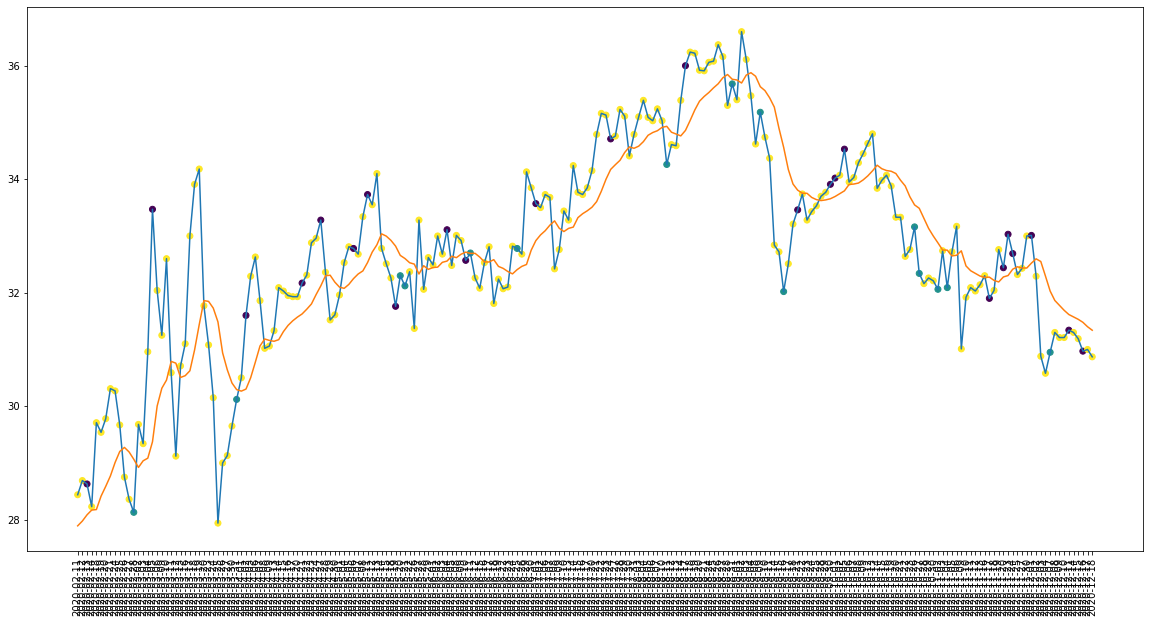

In [125]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

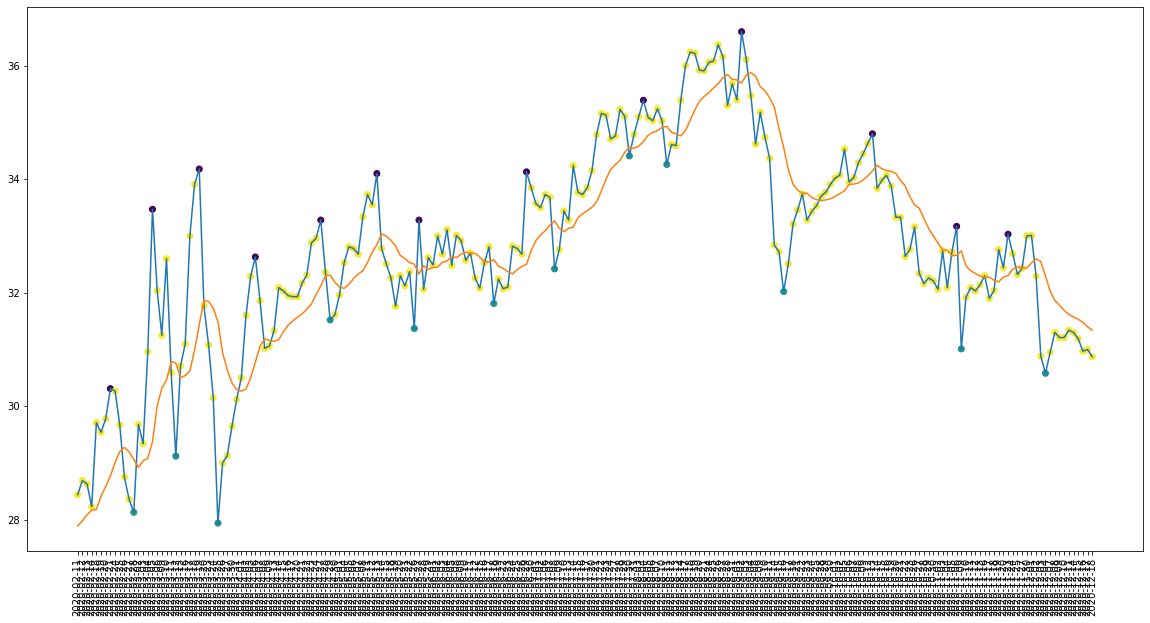

In [126]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [127]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 10
actual holds but predicted buy: 12
actual holds but predicted sell: 21
actual predicted holds: 160
Percentage buys correct: 30.76923076923077%
Percentage sells correct: 23.076923076923077%
Percentage holds correct: 82.90155440414507%
actual buys: 13
actual sells: 13
actual holds: 193
[28.229999542236328, 28.440000534057607, 28.6299991607666, 28.690000534057607, 29.540000915527344, 29.709999084472656, 29.78000068664551, 30.270000457763672, 30.309999465942386]
[28.1299991607666, 28.36000061035156, 28.75, 29.34000015258789, 29.670000076293945, 29.68000030517578, 29.78000068664551, 30.270000457763672, 30.309999465942386]
Percentage buys correct: 53.333333333333336%
Percentage sells correct: 54.166666666666664%
Percentage holds correct: 81.56424581005587%


In [128]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $28.1299991607666
Shares owned at the moment: 354
Cash capital at the moment: $14.595742905616135


Price increase from previously bought: 18.656993017693036%
Share price: $33.470001220703125
Shares owned at the moment: 0
Cash capital at the moment: $11830.393128846168


Share price: $30.1200008392334
Shares owned at the moment: 391
Cash capital at the moment: $21.086269803523464


Price increase from previously bought: 6.51318857402714%
Share price: $32.169998168945305
Shares owned at the moment: 0
Cash capital at the moment: $12564.964763329977


Share price: $32.299999237060554
Shares owned at the moment: 387
Cash capital at the moment: $30.489784399500422


Stop Loss Activated!

Share price: $31.3700008392334
Shares owned at the moment: 0
Cash capital at the moment: $12137.29458578967


Share price: $32.700000762939446
Shares owned at the moment: 370
Cash capital at the moment: $5.022052725782487


Price increase from previously bought: 5.855680592855794%
Share price: 

In [129]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10793.414230489732
profit gained: 7.934142304897322%


In [130]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.802752,0.0%,11.11111111111111%,87.43718592964824%,55.55555555555556%,41.1764705882353%,82.19895287958116%,-26.182976346344933%,2.2610537871217273%
1,0.780822,30.76923076923077%,7.6923076923076925%,86.01036269430051%,60.0%,68.75%,81.28342245989305%,17.954822250075267%,7.934142304897322%
2,0.821101,40.0%,11.11111111111111%,87.43718592964824%,57.89473684210526%,54.54545454545455%,84.49197860962566%,-3.265412074813976%,2.2610537871217273%
3,0.762557,30.76923076923077%,23.076923076923077%,82.90155440414507%,53.333333333333336%,54.166666666666664%,81.56424581005587%,18.41236269859306%,7.934142304897322%


In [131]:
experiment

'KR Variation 6 CNN Images Experiment'

In [132]:
log.to_csv('{}.csv'.format(experiment))